In [4]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
    sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [5]:
env = gym.envs.make("MountainCar-v0")

[2018-02-19 23:21:11,903] Making new env: MountainCar-v0


In [9]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
# Used to convert a state to a featurized representation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [119]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
                
        # TODO: Implement this!
        if a is not None:
            prediction = self.models[a].predict([self.featurize_state(s)])
            return prediction[0]
        
        else:
            predictions = np.array([self.models[i].predict([self.featurize_state(s)]) for i in range(env.action_space.n)])
            return predictions.reshape(-1)
            
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
        self.models[a].partial_fit([self.featurize_state(s)], [y])

In [120]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [121]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    nA = env.action_space.n
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, nA)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward))
        sys.stdout.flush()
        
        # TODO: Implement this!
        state = env.reset()
        
        for t in itertools.count():
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA, p=policy(state))
            
            # Perform the action -> Get the reward and observe the next state
            new_state, reward, terminated, _ = env.step(action)
            new_action = np.random.choice(nA, p=policy(new_state))
                        
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            q_values_new_state = estimator.predict(new_state)

            # value that we should have got
            # The Q-learning target policy is a greedy one, hence the `max`
            td_target = reward + discount_factor * np.max(q_values_new_state)
            estimator.update(state, action, td_target)            
            
            # update current state
            state = new_state
            
            if terminated:
                break
    
    return stats

In [122]:
estimator = Estimator()

In [123]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 100, epsilon=0.0)

Episode 1/100 (0.0)
Episode 2/100 (-200.0)
Episode 3/100 (-200.0)
Episode 4/100 (-200.0)
Episode 5/100 (-200.0)
Episode 6/100 (-200.0)
Episode 7/100 (-200.0)
Episode 8/100 (-200.0)
Episode 9/100 (-200.0)
Episode 10/100 (-200.0)
Episode 11/100 (-200.0)
Episode 12/100 (-200.0)
Episode 13/100 (-200.0)
Episode 14/100 (-200.0)
Episode 15/100 (-200.0)
Episode 16/100 (-200.0)
Episode 17/100 (-200.0)
Episode 18/100 (-200.0)
Episode 19/100 (-200.0)
Episode 20/100 (-200.0)
Episode 21/100 (-200.0)
Episode 22/100 (-200.0)
Episode 23/100 (-200.0)
Episode 24/100 (-200.0)
Episode 25/100 (-200.0)
Episode 26/100 (-200.0)
Episode 27/100 (-200.0)
Episode 28/100 (-200.0)
Episode 29/100 (-200.0)
Episode 30/100 (-200.0)
Episode 31/100 (-200.0)
Episode 32/100 (-200.0)
Episode 33/100 (-200.0)
Episode 34/100 (-200.0)
Episode 35/100 (-178.0)
Episode 36/100 (-200.0)
Episode 37/100 (-200.0)
Episode 38/100 (-200.0)
Episode 39/100 (-173.0)
Episode 40/100 (-161.0)
Episode 41/100 (-200.0)
Episode 42/100 (-200.0)
Epis

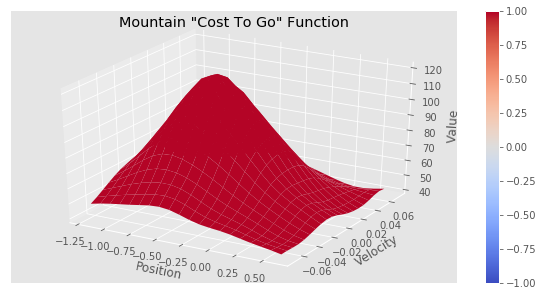

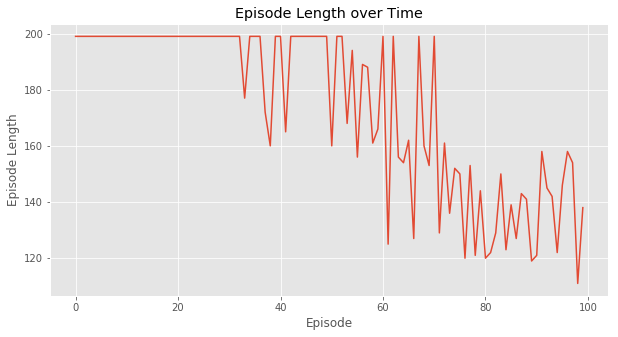

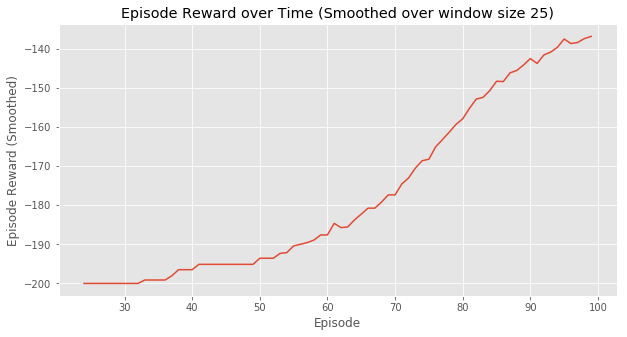

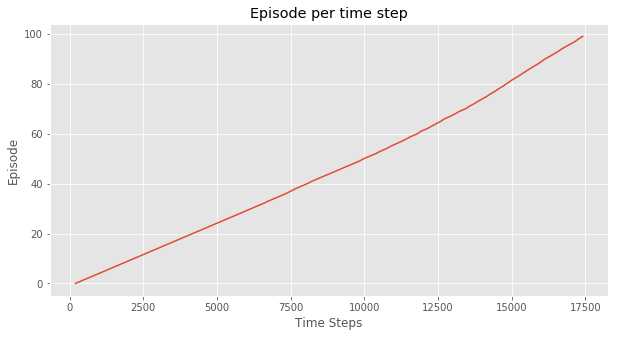

(<matplotlib.figure.Figure at 0x7f758fa78090>,
 <matplotlib.figure.Figure at 0x7f758dfb7350>)

In [124]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)